In [386]:
import os
import sys
import numpy as np
from scipy.stats import linregress
from scipy.linalg import sqrtm
from scipy.spatial.distance import cdist
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import SOAPTools

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

In [387]:
def GaussianKernel(XA, XB, gamma):
    D = cdist(XA, XB, metric='sqeuclidean')
    return np.exp(-D*gamma)

def KPCovR(KNM, KMM, Y, alpha=0.0, n_kpca=None, loss=False):
    U, V = np.linalg.eigh(KMM)
    V = V[:, U > 0]
    U = U[U > 0]
    Usqrt = np.diagflat(1.0/np.sqrt(U))
    
    X = np.dot(KNM, V)
    X = np.dot(X, Usqrt)
    X = np.dot(X, V.T)
    
    Kapprox = np.dot(X, X.T)
    Ux, Vx = np.linalg.eigh(np.dot(X.T, X))
    Vx = Vx[:, Ux > 0]
    Ux = Ux[Ux > 0]    
    XTX = np.dot(np.dot(Vx, np.diagflat(1.0/np.sqrt(Ux))), Vx.T)

    Spca = np.dot(XTX, X.T)
    Spca = np.dot(Spca, Kapprox)
    Spca = np.dot(Spca, X)
    Spca = np.dot(Spca, XTX)
    
    Slr = np.dot(XTX, X.T)
    Slr = np.dot(Slr, np.dot(Y, Y.T))
    Slr = np.dot(Slr, X)
    Slr = np.dot(Slr, XTX)
    
    # How we normalize strongly affects the "efficacy" of tuning alpha,
    # i.e., the change in results as alpha is changed.
    # This normalization might make sense, as it gives good tuning,
    # and in the linear version we normalize by the norms of X and Y squared.
    # The (non-squared) kernel norm is (order of magnitude) comparable to the squared norm of X
    S = alpha*Spca/np.linalg.norm(Kapprox) + (1.0-alpha)*Slr/np.linalg.norm(Y)**2
    #S = alpha*Spca/np.linalg.norm(Kapprox)**2 + (1.0-alpha)*Slr/np.linalg.norm(Y)**2
    #S = alpha*Spca/np.linalg.norm(Kapprox)**2 + (1.0-alpha)*Slr/np.linalg.norm(np.dot(Y, Y.T))**2
    #print 'S:', np.linalg.norm(S)
    #print 'Spca normed:', np.linalg.norm(Spca)/np.linalg.norm(Kapprox)**2
    #print np.linalg.norm(Slr)/np.linalg.norm(np.dot(Y, Y.T))**2
    #print 'Slr normed:', np.linalg.norm(Slr)/np.linalg.norm(Y)**2
    #print 'Spca:', np.linalg.norm(Spca)
    #print 'Slr:', np.linalg.norm(Slr)
    
    UU, VV = np.linalg.eigh(S)
    UU = np.flip(UU, axis=0)
    VV = np.flip(VV, axis=1)
    VV = VV[:, UU > 0]
    UU = UU[UU > 0]
    W = np.dot(XTX, VV[:, 0:n_kpca])
    
    Px = np.dot(np.dot(W.T, X.T), X)
    Py = np.dot(np.dot(W.T, X.T), Y)
    
    Xp = np.dot(X, W)
        
    # Undo whitening and scaling by norm;
    # also need to change the scaling here depending on the scaling in S 
    # (should be the square root of the scaling of the PCA term of S)
    Xp = np.dot(Xp, np.diagflat(np.sqrt(UU[0:n_kpca])))*np.sqrt(np.linalg.norm(Kapprox))
    
    Xr = np.dot(np.dot(X, W), Px)
    
    By = np.dot(W, Py)
    
    Yp = np.dot(X, By)
    
    #print 'X:', np.linalg.norm(X)
    #print 'Kapprox:', np.linalg.norm(Kapprox)
    #print 'KMM:', np.linalg.norm(KMM)
    #print 'KNM:', np.linalg.norm(KNM)
    #print 'W:', np.linalg.norm(W)
    #print 'Y:', np.linalg.norm(Y)
    #print 'YY:', np.linalg.norm(np.dot(Y, Y.T))
        
    if loss is True:
        T = np.dot(X, W)
        Lx = np.linalg.norm(X - np.dot(T, Px))**2 / np.linalg.norm(X)**2
        Ly = np.linalg.norm(Y - np.dot(T, Py))**2 / np.linalg.norm(Y)**2
        
        return Xp, Xr, Yp, UU, By, Lx, Ly
    
    else:
        return Xp, Xr, Yp, UU, By
        
def cc(x, p):
    """
        Compute the Pearson correlation coefficient
        
        ---Arguments---
        x: feature data (e.g., SOAP KPCA)
        p: property data (e.g., decomposed volumes)
    """
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

In [388]:
# make toy data
toyX = np.zeros((100, 2))
toyY = np.ones(100)
toyY[0:50] = 5.0
toyY[50:] = 10.0
rad = np.linspace(0, 2*np.pi, 50)
r1 = 2
r2 = 5
for rdx, r in enumerate(rad):
    toyX[rdx, 0] = r1*np.cos(r)
    toyX[rdx, 1] = r1*np.sin(r)
    toyX[rdx+50, 0] = r2*np.cos(r)
    toyX[rdx+50, 1] = r2*np.sin(r)

col_idxs = np.arange(0, 100)
np.random.shuffle(col_idxs)
col_idxs = col_idxs[0:50]

# How does centering work with KMM and KNM?
# Need to center the gaussian kernels?
#toyKNM = GaussianKernel(toyX, toyX[col_idxs, :], 1)
#toyKMM = GaussianKernel(toyX[col_idxs, :], toyX[col_idxs, :], 1)

toyKNM = np.dot(toyX, toyX[col_idxs, :].T)
toyKMM = np.dot(toyX[col_idxs, :], toyX[col_idxs, :].T)

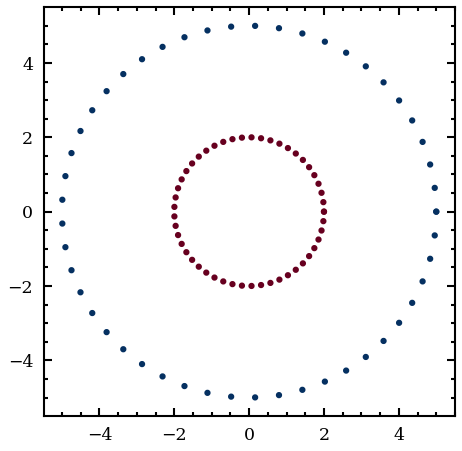

In [389]:
plt.scatter(toyX[:, 0], toyX[:, 1], c=toyY, cmap='RdBu')
plt.show()

In [390]:
toyXp, toyXr, toyYp, toyUU, toyBy = KPCovR(toyKNM, toyKMM, toyY, n_kpca=2, alpha=1)

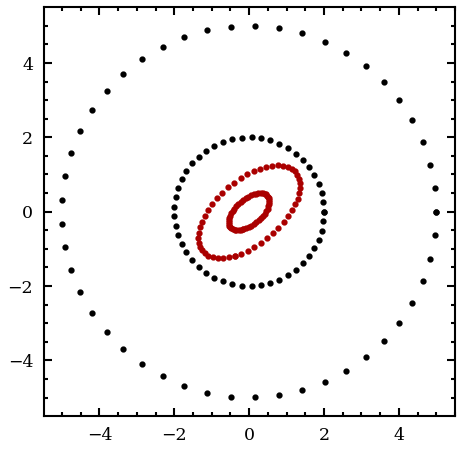

In [391]:
plt.scatter(toyX[:, 0], toyX[:, 1], zorder=2)
plt.scatter(toyXr[:, 0], toyXr[:, 1], zorder=3)
#plt.scatter(toyXp[:, 0], toyXp[:, 1], zorder=3)
plt.show()

In [403]:
# Read SOAP vectors
inputFiles = SOAPTools.read_input('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/PCA/6.0/SOAPFiles.dat')

soaps = []
for i in inputFiles:
    soaps.append(SOAPTools.read_SOAP(i))
    
soaps = np.concatenate(soaps)

energies = np.loadtxt('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')
volumes = np.loadtxt('../../Zeolites_IZA-DEEM/Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')

In [404]:
# Select random points
p = 5000
n_kpca = 10
n_kpca_plot = 10
random_idxs = np.arange(0, soaps.shape[0])
np.random.shuffle(random_idxs)
random_idxs = random_idxs[0:p]
random_idxs.sort()
col_idxs = np.arange(0, 2000)
np.random.shuffle(col_idxs)
col_idxs = col_idxs[0:500]

In [405]:
Y = np.column_stack((volumes[random_idxs], energies[random_idxs]))
X = soaps[random_idxs]

#X = scale(X)
#Y = scale(Y)
X -= np.mean(X, axis=0)
Y -= np.mean(Y, axis=0)

kpca = KernelPCA(n_components=n_kpca, kernel='linear', gamma=0.1)
Xkpca = kpca.fit_transform(X)

In [406]:
# build kernel
KNM = np.dot(X, X[col_idxs, :].T)
KMM = np.dot(X[col_idxs, :], X[col_idxs, :].T)
#KNM = GaussianKernel(X, X[col_idxs, :], 0.1)
#KMM = GaussianKernel(X[col_idxs, :], X[col_idxs, :], 0.1)

In [407]:
Xp, Xr, Yp, UU, By = KPCovR(KNM, KMM, Y, n_kpca=n_kpca, alpha=1)

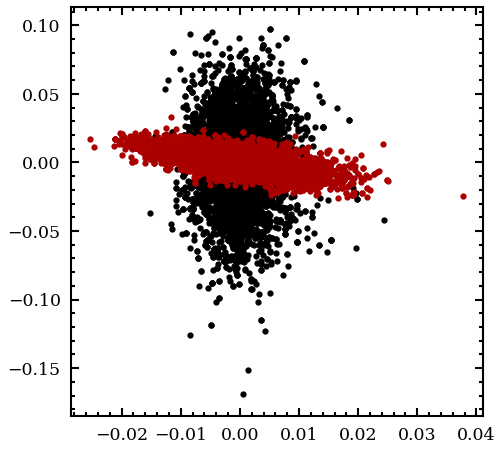

In [408]:
plt.scatter(X[:, 0], X[:, 1], zorder=2)
plt.scatter(Xr[:, 0], Xr[:, 1], zorder=3)
#plt.scatter(-Xkpca[:, 0], -Xkpca[:, 1], zorder=2)
#plt.scatter(Xp[:, 0], Xp[:, 1], zorder=3)
plt.show()

In [409]:
print(Xp.shape)
print(X.shape)

(5000, 10)
(5000, 500)


In [410]:
print('Volumes:', np.mean(np.abs(Yp[:, 0] - Y[:, 0])))
print('Energies:', np.mean(np.abs(Yp[:, 1] - Y[:, 1])))

Volumes: 2.672923271424958
Energies: 7.055810630897431


In [411]:
LRV = LinearRegression().fit(X, Y[:, 0])
Vp = LRV.predict(X)

LRE = LinearRegression().fit(X, Y[:, 1])
Ep = LRE.predict(X)

print('Volumes:', np.mean(np.abs(Vp - Y[:, 0])))
print('Energies:', np.mean(np.abs(Ep - Y[:, 1])))

Volumes: 0.16187321931945947
Energies: 0.2839418482869385


In [412]:
np.savetxt('Xkpca.dat', Xkpca)
np.savetxt('Xpk.dat', Xp) # linear agrees! and MAE of energy/volume is close too (< 0.01)

--- Alpha = 0.01 ---
0.16406469529653805
--- Alpha = 0.25 ---
0.23483067409349642
--- Alpha = 0.5 ---
0.49055652688650386
--- Alpha = 0.75 ---
1.122998247324339
--- Alpha = 0.99 ---
2.6693647001153837


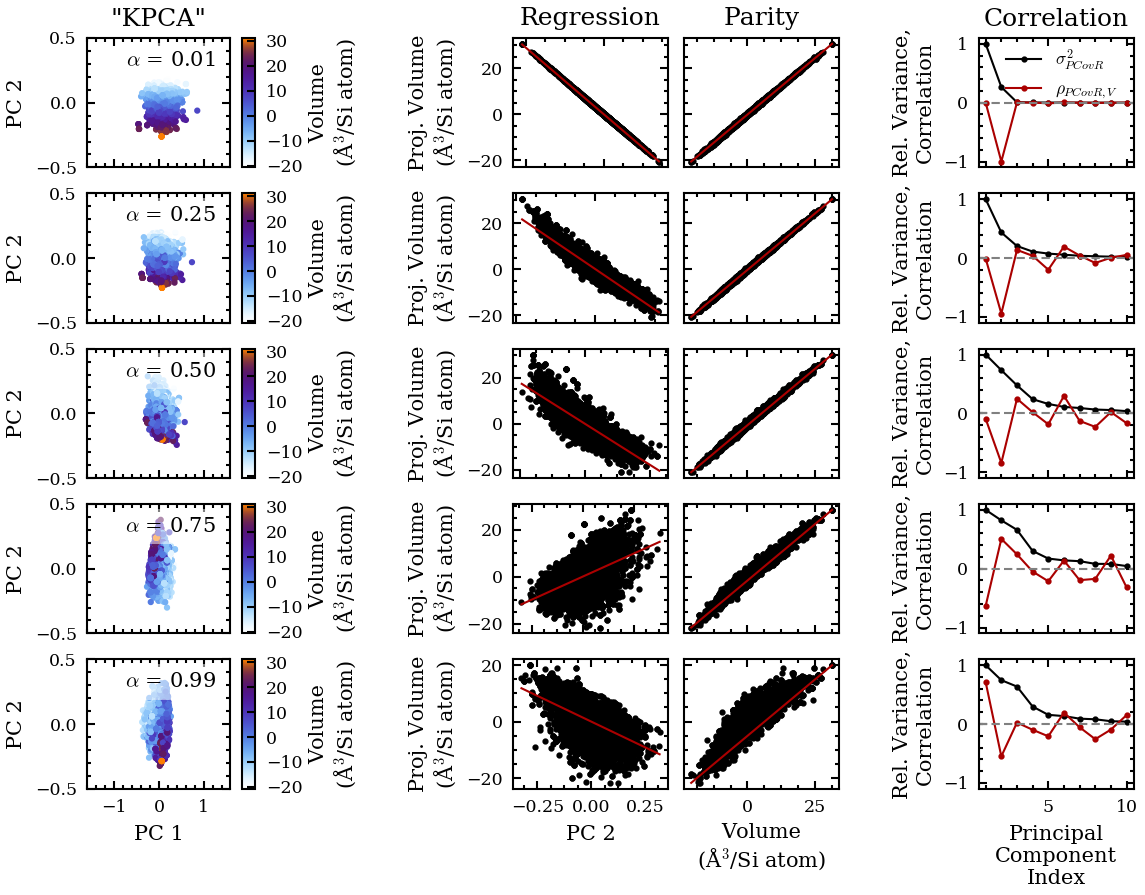

In [413]:
fig = plt.figure(figsize=(9.0, 6.5))
gs = mpl.gridspec.GridSpec(5, 6, width_ratios=(1, 0.65, 0.65, 0.65, 0.45, 0.65), hspace=0.2, wspace=0.1)

for adx, a in enumerate((0.01, 0.25, 0.50, 0.75, 0.99)):
#for adx, a in enumerate((0.90, 0.95, 0.99, 0.999, 0.9999)):
    axsKPCA = fig.add_subplot(gs[adx, 0])
    axsLR = fig.add_subplot(gs[adx, 2])
    axsP = fig.add_subplot(gs[adx, 3])
    axsCorr = fig.add_subplot(gs[adx, 5])
    
    # PCovR
    Xp, Xr, Yp, U, By = KPCovR(KNM, KMM, Y, alpha=a, n_kpca=n_kpca)
    m, b, r, p, s = linregress(Xp[:, 1], Yp[:, 0])

    print('--- Alpha =', a, '---')
    #print np.mean(np.abs(X[:, 0:n_kpca]-Xp), axis=0)[0:3]
    print(np.mean(np.abs(Y[:, 0]-Yp[:, 0])))
    
    # Correlation coefficients
    varV = np.var(volumes)
    varX = np.var(Xp, axis=0)

    ccV = np.zeros(n_kpca)

    for i in range(0, n_kpca):
        #ccV[i] = cc(Xp[:, i], Y[:, 0])
        ccV[i] = cc(Xp[:, i], Yp[:, 0])

    # Plotting
    s = axsKPCA.scatter(Xp[:, 0], Xp[:, 1], c=Y[:, 0], cmap='cbarHot')
    axsKPCA.set_xlim([-1.6, 1.6])
    axsKPCA.set_ylim([-0.50, 0.50])
    #axsKPCA.scatter(-Xkpca[:, 0]*0.05, Xkpca[:, 1]*0.05, c='gray', alpha=1)
    if adx == 0:
        axsKPCA.set_title('"KPCA"')
    if adx == 4:
        axsKPCA.set_xlabel('PC 1')
    else:
        axsKPCA.set_xticklabels([])
        
    axsKPCA.set_ylabel('PC 2')
    
    axsLR.scatter(Xp[:, 1], Yp[:, 0])
    x = np.linspace(Xp[:, 1].min(), Xp[:, 1].max())
    axsLR.plot(x, m*x+b, linestyle='-', color=color_list[1])
    if adx == 0:
        axsLR.set_title('Regression')
    if adx == 4:
        axsLR.set_xlabel('PC 2')
    else:
        axsLR.set_xticklabels([])
        
    axsLR.set_ylabel('Proj. Volume\n' + ur'(\u00c5$^3$/Si atom)')
    
    axsP.scatter(Y[:, 0], Yp[:, 0])
    axsP.plot([Y[:, 0].min(), Y[:, 0].max()], [Yp[:, 0].min(), Yp[:, 0].max()], color=color_list[1])
    if adx == 0:
        axsP.set_title('Parity')
    if adx == 4:
        axsP.set_xlabel('Volume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsP.set_xticklabels([])
        
    axsP.set_yticklabels([])
    
    x = np.arange(1, n_kpca_plot+1)
    axsCorr.plot(x, varX[0:n_kpca_plot]/varX[0], marker='o', label=r'$\sigma^2_{PCovR}$')
    axsCorr.plot(x, ccV[0:n_kpca_plot], marker='o', label=r'$\rho_{PCovR, V}$')
    if adx == 0:
        axsCorr.set_title('Correlation')
        axsCorr.legend(loc='upper right', bbox_to_anchor=(1.0, 1.05))
    if adx == 4:
        axsCorr.set_xlabel('Principal\nComponent\nIndex')
    else:
        axsCorr.set_xticklabels([])
        
    axsCorr.set_ylim([-1.1, 1.1])
    axsCorr.set_ylabel('Rel. Variance,\nCorrelation')
    axsCorr.axhline(y=0, linestyle='--', color='gray')
    
    cb = fig.colorbar(s, ax=axsKPCA, aspect=10, fraction=0.35)
    cb.set_label('Volume\n' + ur'(\u00c5$^3$/Si atom)')
    cb.ax.minorticks_off()
    
    axsKPCA.text(0.90, 0.90, r'$\alpha$ = %.2f' % a, 
                horizontalalignment='right', verticalalignment='top',
                transform=axsKPCA.transAxes, bbox=dict(facecolor='w', alpha=0.5, edgecolor='none'))

fig.savefig('../Results/DEEM_1k/KPCovR_volumes_test.pdf', bbox_inches='tight')
fig.savefig('../Results/DEEM_1k/KPCovR_volumes_test.png', bbox_inches='tight')
plt.show()

--- Alpha = 0.01 ---
0.2882041401618619
--- Alpha = 0.25 ---
0.2998227273841735
--- Alpha = 0.5 ---
0.3790302683827029
--- Alpha = 0.75 ---
0.7630318510810372
--- Alpha = 0.99 ---
6.700448991442347


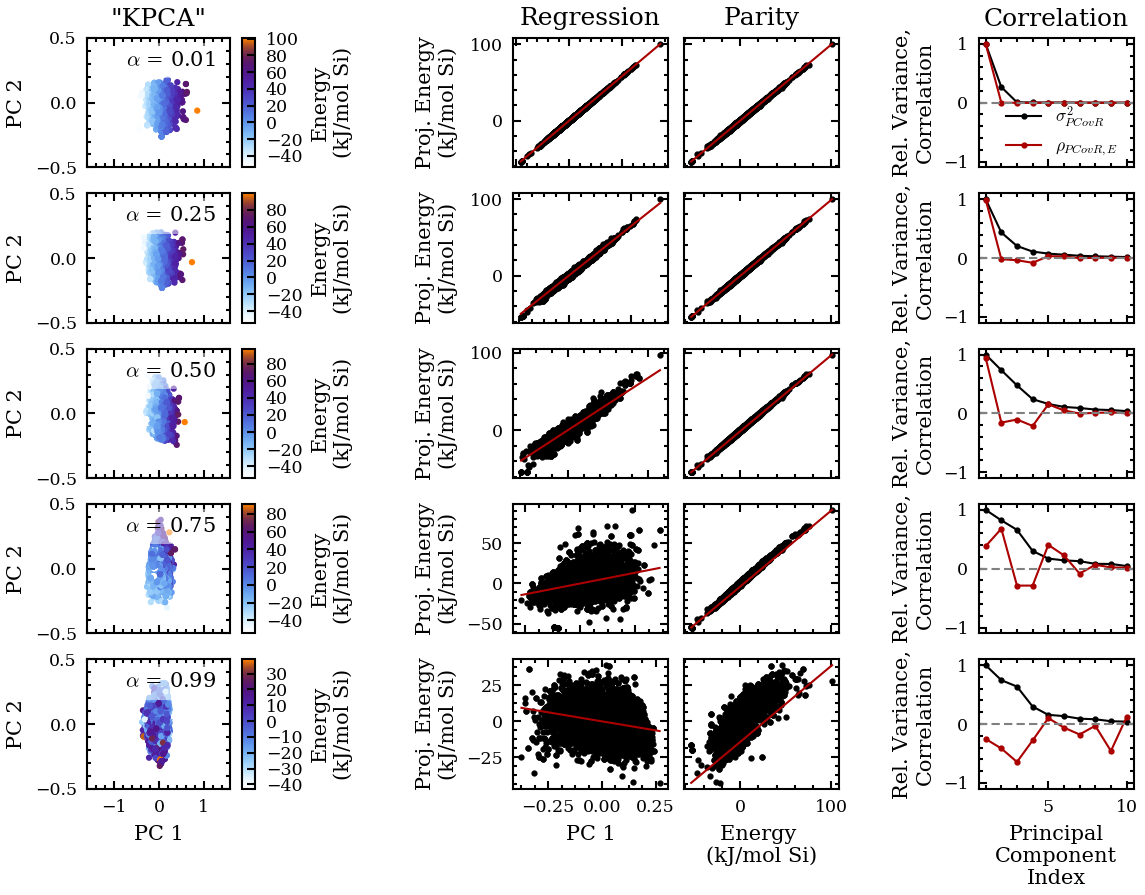

In [414]:
fig = plt.figure(figsize=(9.0, 6.5))
gs = mpl.gridspec.GridSpec(5, 6, width_ratios=(1, 0.65, 0.65, 0.65, 0.45, 0.65), hspace=0.2, wspace=0.1)

for adx, a in enumerate((0.01, 0.25, 0.50, 0.75, 0.99)):
    axsKPCA = fig.add_subplot(gs[adx, 0])
    axsLR = fig.add_subplot(gs[adx, 2])
    axsP = fig.add_subplot(gs[adx, 3])
    axsCorr = fig.add_subplot(gs[adx, 5])
    
    # PCovR
    Xp, Xr, Yp, Bx, By = KPCovR(KNM, KMM, Y, alpha=a, n_kpca=n_kpca)
    m, b, r, p, s = linregress(Xp[:, 0], Yp[:, 1])

    print('--- Alpha =', a, '---')
    #print np.mean(np.abs(X[:, 0:n_kpca]-Xp), axis=0)[0:3]
    print(np.mean(np.abs(Y[:, 1]-Yp[:, 1])))
    
    # Correlation coefficients
    varE = np.var(energies)
    varX = np.var(Xp, axis=0)

    ccE = np.zeros(n_kpca)

    for i in range(0, n_kpca):
        #ccE[i] = cc(Xp[:, i], Y[:, 1])
        ccE[i] = cc(Xp[:, i], Yp[:, 1])

    # Plotting
    s = axsKPCA.scatter(Xp[:, 0], Xp[:, 1], c=Yp[:, 1], cmap='cbarHot')
    axsKPCA.set_xlim([-1.6, 1.6])
    axsKPCA.set_ylim([-0.50, 0.50])
    #axsKPCA.scatter(-Xkpca[:, 0]*0.05, Xkpca[:, 1]*0.05, c='gray', alpha=1)
    if adx == 0:
        axsKPCA.set_title('"KPCA"')
    if adx == 4:
        axsKPCA.set_xlabel('PC 1')
    else:
        axsKPCA.set_xticklabels([])
        
    axsKPCA.set_ylabel('PC 2')
    
    axsLR.scatter(Xp[:, 0], Yp[:, 1])
    x = np.linspace(Xp[:, 0].min(), Xp[:, 0].max())
    axsLR.plot(x, m*x+b, linestyle='-', color=color_list[1])
    if adx == 0:
        axsLR.set_title('Regression')
    if adx == 4:
        axsLR.set_xlabel('PC 1')
    else:
        axsLR.set_xticklabels([])
        
    axsLR.set_ylabel('Proj. Energy\n(kJ/mol Si)')
    
    axsP.scatter(Y[:, 1], Yp[:, 1])
    axsP.plot([Y[:, 1].min(), Y[:, 1].max()], [Yp[:, 1].min(), Yp[:, 1].max()], color=color_list[1])
    if adx == 0:
        axsP.set_title('Parity')
    if adx == 4:
        axsP.set_xlabel('Energy \n(kJ/mol Si)')
    else:
        axsP.set_xticklabels([])
        
    axsP.set_yticklabels([])
    
    x = np.arange(1, n_kpca_plot+1)
    axsCorr.plot(x, varX[0:n_kpca_plot]/varX[0], marker='o', label=r'$\sigma^2_{PCovR}$')
    axsCorr.plot(x, ccE[0:n_kpca_plot], marker='o', label=r'$\rho_{PCovR, E}$')
    if adx == 0:
        axsCorr.set_title('Correlation')
        axsCorr.legend(loc='lower right', bbox_to_anchor=(1.0, -0.05))
    if adx == 4:
        axsCorr.set_xlabel('Principal\nComponent\nIndex')
    else:
        axsCorr.set_xticklabels([])
       
    axsCorr.set_ylim([-1.1, 1.1])
    axsCorr.set_ylabel('Rel. Variance,\nCorrelation')
    axsCorr.axhline(y=0, linestyle='--', color='gray')
    
    cb = fig.colorbar(s, ax=axsKPCA, aspect=10, fraction=0.35)
    cb.set_label('Energy\n(kJ/mol Si)')
    cb.ax.minorticks_off()
    
    axsKPCA.text(0.90, 0.90, r'$\alpha$ = %.2f' % a, 
                horizontalalignment='right', verticalalignment='top',
                transform=axsKPCA.transAxes, bbox=dict(facecolor='w', alpha=0.5, edgecolor='none'))
    
    fig.align_ylabels()

fig.savefig('../Results/DEEM_1k/KPCovR_energies_test.pdf', bbox_inches='tight')
fig.savefig('../Results/DEEM_1k/KPCovR_energies_test.png', bbox_inches='tight')
plt.show()